In this tutorial, we'll demonstrate the Argoverse 2.0 map API, and visualize some of the map data.

In [1]:
from argparse import Namespace
from pathlib import Path

In [5]:
# path to where the logs live
dataroot = "/data/scratch/gcaz/sensor/train"

# unique log identifier
log_id = "00a6ffc1-6ce9-3bc3-a060-6006e9893a1a"

In [6]:
args = Namespace(**{"dataroot": Path(dataroot), "log_id": Path(log_id)})

In [7]:
import argparse
from pathlib import Path
from typing import List

import matplotlib

import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable

import av2.geometry.polyline_utils as polyline_utils
import av2.rendering.vector as vector_plotting_utils
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from av2.map.map_api import ArgoverseStaticMap, LaneSegment

First, we'll plot the lane graph and crosswalks, with crosswalks colored purple, and the lanes colored green.

In [8]:
# scaled to [0,1] for matplotlib.
PURPLE_RGB = [201, 71, 245]
PURPLE_RGB_MPL = np.array(PURPLE_RGB) / 255

DARK_GRAY_RGB = [40, 39, 38]
DARK_GRAY_RGB_MPL = np.array(DARK_GRAY_RGB) / 255

In [9]:
def single_log_teaser(args: argparse.Namespace) -> None:
    """
    For a single log, render all local crosswalks in green, and pedestrian crossings in purple,
    in a bird's eye view.
    """
    log_map_dirpath = Path(args.dataroot) / args.log_id / "map"
    avm = ArgoverseStaticMap.from_map_dir(log_map_dirpath, build_raster=False)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()

    for _, ls in avm.vector_lane_segments.items():
        # right_ln_bnd
        # left_ln_bnd
        vector_plotting_utils.draw_polygon_mpl(ax, ls.polygon_boundary, color="g", linewidth=0.5)
        vector_plotting_utils.plot_polygon_patch_mpl(ls.polygon_boundary, ax, color="g", alpha=0.2)

    # plot all pedestrian crossings
    for _, pc in avm.vector_pedestrian_crossings.items():
        vector_plotting_utils.draw_polygon_mpl(ax, pc.polygon, color="m", linewidth=0.5)
        vector_plotting_utils.plot_polygon_patch_mpl(pc.polygon, ax, color="m", alpha=0.2)

    plt.show()

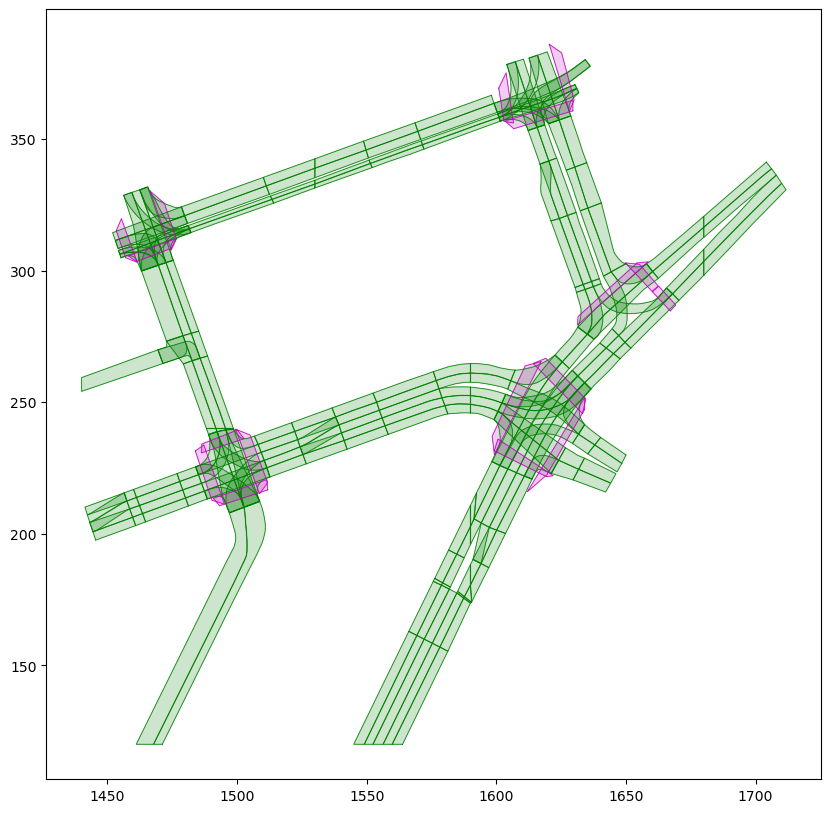

In [10]:
single_log_teaser(args)

In [11]:
def visualize_raster_layers(args: argparse.Namespace) -> None:
    """Visualize the ground surface height/elevation map, w/ a colorbar indicating the value range.

    Also, visualize side-by-side plots of the 3 raster arrays -- ground height, drivable area, ROI.
    """
    log_map_dirpath = Path(args.dataroot) / args.log_id / "map"
    avm = ArgoverseStaticMap.from_map_dir(log_map_dirpath, build_raster=True)

    height_array = avm.raster_ground_height_layer.array
    ax = plt.subplot()
    plt.title("Ground surface height (@ 30 centimeter resolution).")
    img = plt.imshow(np.flipud(height_array))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img, cax=cax)
    plt.show()

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(np.flipud(height_array))
    plt.title("Ground Surface Height")

    plt.subplot(1, 3, 2)
    da_array = avm.raster_drivable_area_layer.array
    plt.imshow(np.flipud(da_array))
    plt.title("Drivable Area (rasterized \nfrom vector polygons)")

    plt.subplot(1, 3, 3)
    roi_array = avm.raster_roi_layer.array
    plt.imshow(np.flipud(roi_array))
    plt.title("Region of Interest (ROI)")
    plt.show()

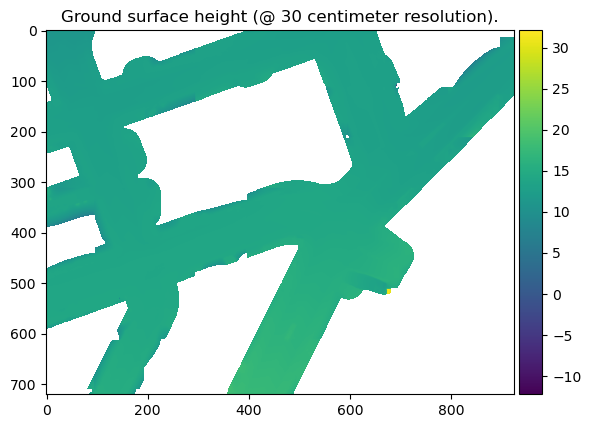

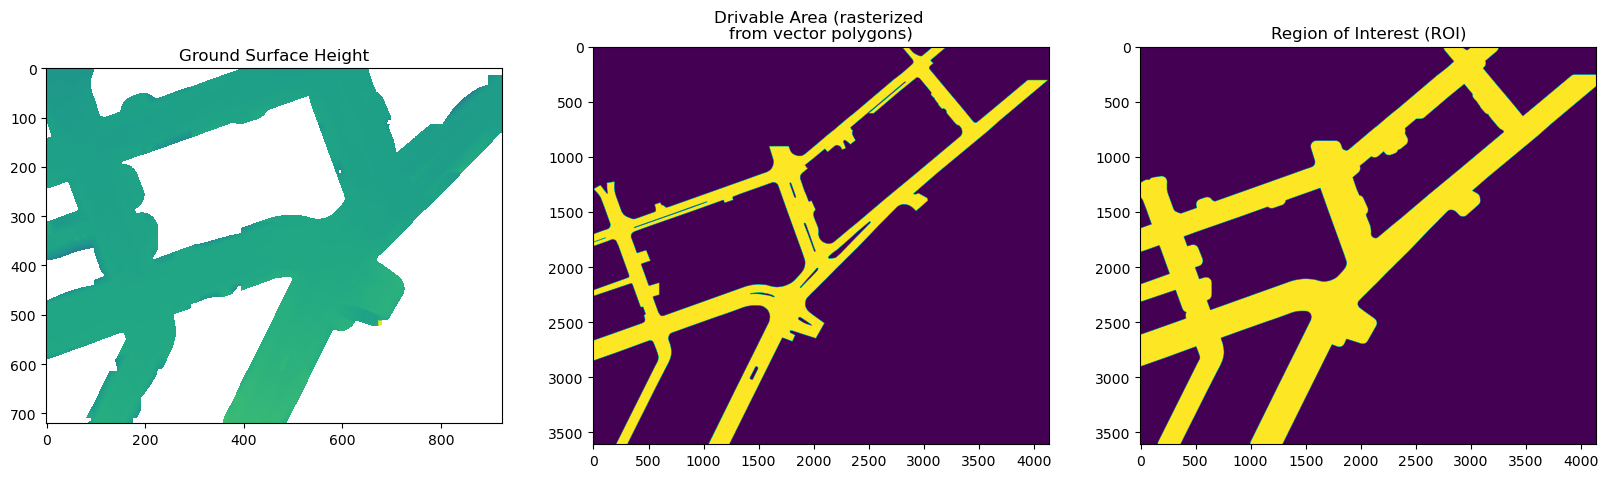

In [12]:
visualize_raster_layers(args)

In [13]:
def plot_lane_segments(
    ax: matplotlib.axes.Axes, lane_segments: List[LaneSegment], lane_color: np.ndarray = DARK_GRAY_RGB_MPL
) -> None:
    """

    Args:
        ax:
        lane_segments:
    """
    for ls in lane_segments:
        pts_city = ls.polygon_boundary
        ALPHA = 1.0  # 0.1
        vector_plotting_utils.plot_polygon_patch_mpl(
            polygon_pts=pts_city, ax=ax, color=lane_color, alpha=ALPHA, zorder=1
        )

        for bound_type, bound_city in zip(
            [ls.left_mark_type, ls.right_mark_type], [ls.left_lane_boundary, ls.right_lane_boundary]
        ):
            if "YELLOW" in bound_type:
                mark_color = "y"
            elif "WHITE" in bound_type:
                mark_color = "w"
            else:
                mark_color = "grey"  # "b" lane_color #

            LOOSELY_DASHED = (0, (5, 10))

            if "DASHED" in bound_type:
                linestyle = LOOSELY_DASHED
            else:
                linestyle = "solid"

            if "DOUBLE" in bound_type:
                left, right = polyline_utils.get_double_polylines(
                    polyline=bound_city.xyz[:, :2], width_scaling_factor=0.1
                )
                ax.plot(left[:, 0], left[:, 1], mark_color, alpha=ALPHA, linestyle=linestyle, zorder=2)
                ax.plot(right[:, 0], right[:, 1], mark_color, alpha=ALPHA, linestyle=linestyle, zorder=2)
            else:
                ax.plot(
                    bound_city.xyz[:, 0],
                    bound_city.xyz[:, 1],
                    mark_color,
                    alpha=ALPHA,
                    linestyle=linestyle,
                    zorder=2,
                )

In [14]:
def argoverse2_sensor_dataset_teaser(args: argparse.Namespace, save_plot: bool = False) -> None:
    """
    Visualize both ego-vehicle poses and the per-log local vector map.

    Crosswalks are plotted in purple. Lane segments plotted in dark gray. Ego-pose in red.
    """
    loader = AV2SensorDataLoader(data_dir=args.dataroot, labels_dir=args.dataroot)

    fig = plt.figure(1, figsize=(10, 10))
    ax = fig.add_subplot(111)

    log_map_dirpath = Path(args.dataroot) / args.log_id / "map"

    avm = ArgoverseStaticMap.from_map_dir(log_map_dirpath, build_raster=False)

    # retain every pose first.
    traj_ns = loader.get_subsampled_ego_trajectory(args.log_id, sample_rate_hz=1e9)
    # now, sample @ 1 Hz
    traj_1hz = loader.get_subsampled_ego_trajectory(args.log_id, sample_rate_hz=1.0)
    med_x, med_y = np.median(traj_ns, axis=0)

    # Derive plot area from trajectory (with radius defined in infinity norm).
    view_radius_m = 50
    xlims = [med_x - view_radius_m, med_x + view_radius_m]
    ylims = [med_y - view_radius_m, med_y + view_radius_m]

    crosswalk_color = PURPLE_RGB_MPL
    CROSSWALK_ALPHA = 0.6
    for pc in avm.get_scenario_ped_crossings():
        vector_plotting_utils.plot_polygon_patch_mpl(
            polygon_pts=pc.polygon[:, :2],
            ax=ax,
            color=crosswalk_color,
            alpha=CROSSWALK_ALPHA,
            zorder=3,
        )

    plot_lane_segments(ax=ax, lane_segments=avm.get_scenario_lane_segments())

    ax.plot(traj_ns[:, 0], traj_ns[:, 1], color="r", zorder=4, label="Ego-vehicle pose")
    ax.scatter(
        traj_1hz[:, 0], traj_1hz[:, 1], 100, facecolors="none", edgecolors="r", zorder=4
    )  # marker='o', color="r")

    plt.axis("equal")
    plt.xlim(*xlims)
    plt.ylim(*ylims)
    plt.title(f"Log {args.log_id}")
    plt.axis("off")
    plt.legend()
    plt.tight_layout()
    plt.show()

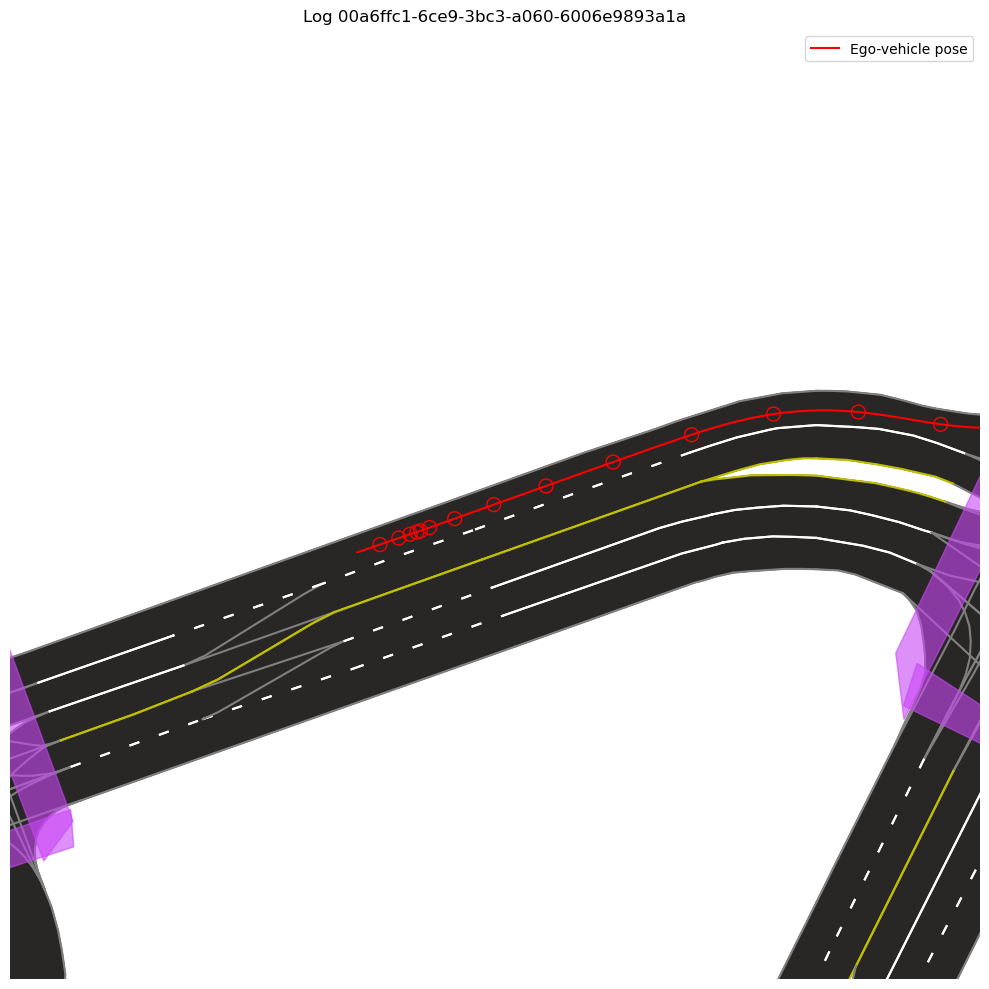

In [15]:
argoverse2_sensor_dataset_teaser(args)

In [46]:
import logging
import os
import sys
from pathlib import Path
from typing import Final

import click
import cv2
import numpy as np

import av2.rendering.color as color_utils
import av2.rendering.rasterize as raster_rendering_utils
import av2.rendering.video as video_utils
import av2.utils.io as io_utils
import av2.utils.raster as raster_utils
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from av2.datasets.sensor.constants import RingCameras
from av2.map.map_api import ArgoverseStaticMap
from av2.rendering.color import GREEN_HEX, RED_HEX
from av2.utils.typing import NDArrayByte, NDArrayFloat, NDArrayInt
import av2

In [102]:
def generate_egoview_overlaid_lidar(
    data_root: Path,
    output_dir: Path,
    log_id: str,
    render_ground_pts_only: bool,
    dump_single_frames: bool,
) -> None:
    """Render LiDAR points from a particular camera's viewpoint (color by ground surface, and apply ROI filtering).

    Args:
        data_root: path to directory where the logs live on disk.
        output_dir: path to directory where renderings will be saved.
        log_id: unique ID for AV2 scenario/log.
        render_ground_pts_only: whether to only render LiDAR points located close to the ground surface.
        dump_single_frames: Whether to save to disk individual RGB frames of the rendering, in addition to generating
            the mp4 file.

    Raises:
        RuntimeError: If vehicle log data is not present at `data_root` for `log_id`.
    """
    loader = AV2SensorDataLoader(data_dir=data_root, labels_dir=data_root)

    log_map_dirpath = data_root / log_id / "map"
    avm = ArgoverseStaticMap.from_map_dir(log_map_dirpath, build_raster=True)
    # print(avm)

    # repeat red to green colormap every 50 m.
    colors_arr_rgb = color_utils.create_colormap(
        color_list=[RED_HEX, GREEN_HEX], n_colors=NUM_RANGE_BINS
    )
    colors_arr_rgb = (colors_arr_rgb * 255).astype(np.uint8)
    colors_arr_bgr: NDArrayByte = np.fliplr(colors_arr_rgb)

    print(list(RingCameras))
    for _, cam_name in enumerate(list(RingCameras)):
        print(type(cam_name))
        cam_im_fpaths = loader.get_ordered_log_cam_fpaths(log_id, cam_name.value)
        num_cam_imgs = len(cam_im_fpaths)

        video_list = []
        # print(cam_im_fpaths)
        for i, im_fpath in enumerate(cam_im_fpaths):
            if i % 50 == 0:
                logging.info(
                    f"\tOn file {i}/{num_cam_imgs} of camera {cam_name} of {log_id}"
                )

            cam_timestamp_ns = int(im_fpath.stem)
            city_SE3_ego = loader.get_city_SE3_ego(log_id, cam_timestamp_ns)
            
            if city_SE3_ego is None:
                logger.exception("missing LiDAR pose")
                continue

            # load feather file path, e.g. '315978406032859416.feather"
            lidar_fpath = loader.get_closest_lidar_fpath((data_root / log_id).name, cam_timestamp_ns)
            # print(lidar_fpath)
            # print(cam_timestamp_ns)
            # print(loader._sdb.get_closest_lidar_timestamp(cam_timestamp_ns, (data_root / log_id).name))
            if lidar_fpath is None:
                # logger.info(
                #     "No LiDAR sweep found within the synchronization interval for %s, so skipping...",
                #     cam_name,
                # )
                continue

            img_bgr = io_utils.read_img(im_fpath, channel_order="BGR")

            lidar_points_ego = io_utils.read_lidar_sweep(lidar_fpath, attrib_spec="xyz")
            lidar_timestamp_ns = int(lidar_fpath.stem)

            # put into city coords, then prune away ground and non-RoI points
            lidar_points_city = city_SE3_ego.transform_point_cloud(lidar_points_ego)
            lidar_points_city = avm.remove_non_drivable_area_points(lidar_points_city)
            is_ground_logicals = avm.get_ground_points_boolean(lidar_points_city)
            # lidar_points_city = lidar_points_city[
            #     is_ground_logicals if render_ground_pts_only else ~is_ground_logicals
            # ]
            lidar_points_ego = city_SE3_ego.inverse().transform_point_cloud(
                lidar_points_city
            )

            # motion compensate always
            (
                uv,
                points_cam,
                is_valid_points,
            ) = loader.project_ego_to_img_motion_compensated(
                points_lidar_time=lidar_points_ego,
                cam_name=cam_name,
                cam_timestamp_ns=cam_timestamp_ns,
                lidar_timestamp_ns=lidar_timestamp_ns,
                log_id=log_id,
            )

            if is_valid_points is None or uv is None or points_cam is None:
                continue

            if is_valid_points.sum() == 0:
                continue

            uv_int: NDArrayInt = np.round(uv[is_valid_points]).astype(np.int32)
            points_cam = points_cam[is_valid_points]
            pt_ranges: NDArrayFloat = np.linalg.norm(points_cam[:, :3], axis=1)
            color_bins: NDArrayInt = np.round(pt_ranges).astype(np.int32)
            # account for moving past 100 meters, loop around again
            color_bins = color_bins % NUM_RANGE_BINS
            uv_colors_bgr = colors_arr_bgr[color_bins]

            img_empty = np.full_like(img_bgr, fill_value=0)
            # print(uv_int)
            # print(uv_colors_bgr)
            # print(img_empty.shape, uv_int.shape, uv_colors_bgr.shape)
            # print(img_empty[uv_int])
            # img_empty[uv_int] = uv_colors_bgr
            # print(img_empty)
            # img_empty = raster_rendering_utils.draw_points_xy_in_img(
            #     img_empty, uv_int, uv_colors_bgr, diameter=5, with_anti_alias=False, sigma=1.0, alpha=0.0
            # )
            # blended_bgr = raster_utils.blend_images(img_bgr, img_empty)
            # frame_rgb = blended_bgr[:, :, ::-1]

            blended_bgr = raster_rendering_utils.draw_points_xy_in_img(
                img_bgr, uv_int, uv_colors_bgr, diameter=5, with_anti_alias=False, sigma=1.0, alpha=0.0
            )
            # blended_bgr = raster_utils.blend_images(img_bgr, img_empty)
            frame_rgb = blended_bgr[:, :, ::-1]

            if dump_single_frames:
                save_dir = output_dir / log_id / cam_name
                os.makedirs(save_dir, exist_ok=True)
                cv2.imwrite(
                    str(save_dir / f"{cam_name}_{lidar_timestamp_ns}.jpg"), blended_bgr
                )

            video_list.append(frame_rgb)

        if len(video_list) == 0:
            raise RuntimeError(
                "No video frames were found; log data was not found on disk."
            )

        video: NDArrayByte = np.stack(video_list).astype(np.uint8)
        video_output_dir = Path(output_dir) / Path("videos")
        video_utils.write_video(
            video=video,
            dst=video_output_dir / f"{log_id}_{cam_name}.mp4",
            fps=RING_CAMERA_FPS,
        )

In [ ]:
# path to where the logs live
dataroot = Path("/data/scratch/gcaz/sensor/train")

# unique log identifier
log_id = Path("00a6ffc1-6ce9-3bc3-a060-6006e9893a1a")

NUM_RANGE_BINS: Final[int] = 50
RING_CAMERA_FPS: Final[int] = 20

generate_egoview_overlaid_lidar(
        data_root=dataroot,
        output_dir="./out11",
        log_id=log_id,
        render_ground_pts_only=False,
        dump_single_frames=False,
    )

[<RingCameras.RING_REAR_LEFT: 'ring_rear_left'>, <RingCameras.RING_SIDE_LEFT: 'ring_side_left'>, <RingCameras.RING_FRONT_LEFT: 'ring_front_left'>, <RingCameras.RING_FRONT_CENTER: 'ring_front_center'>, <RingCameras.RING_FRONT_RIGHT: 'ring_front_right'>, <RingCameras.RING_SIDE_RIGHT: 'ring_side_right'>, <RingCameras.RING_REAR_RIGHT: 'ring_rear_right'>]
<enum 'RingCameras'>


<enum 'RingCameras'>


<enum 'RingCameras'>


<enum 'RingCameras'>


<enum 'RingCameras'>


<enum 'RingCameras'>


<enum 'RingCameras'>


In [43]:
av2_data = AV2SensorDataLoader(data_dir=dataroot, labels_dir=dataroot)

In [44]:
log_id = av2_data.get_log_ids()[0]

In [47]:
lidar_fpaths = av2_data.get_ordered_log_lidar_fpaths(log_id)
lidar_points = av2.utils.io.read_lidar_sweep(lidar_fpaths[0], attrib_spec='xyz')

In [49]:
lidar_points.shape

(98236, 3)

In [50]:
lidar_fpaths

[PosixPath('/data/scratch/gcaz/sensor/train/00a6ffc1-6ce9-3bc3-a060-6006e9893a1a/sensors/lidar/315967376859506000.feather'),
 PosixPath('/data/scratch/gcaz/sensor/train/00a6ffc1-6ce9-3bc3-a060-6006e9893a1a/sensors/lidar/315967376959702000.feather'),
 PosixPath('/data/scratch/gcaz/sensor/train/00a6ffc1-6ce9-3bc3-a060-6006e9893a1a/sensors/lidar/315967377059885000.feather'),
 PosixPath('/data/scratch/gcaz/sensor/train/00a6ffc1-6ce9-3bc3-a060-6006e9893a1a/sensors/lidar/315967377160082000.feather'),
 PosixPath('/data/scratch/gcaz/sensor/train/00a6ffc1-6ce9-3bc3-a060-6006e9893a1a/sensors/lidar/315967377259615000.feather'),
 PosixPath('/data/scratch/gcaz/sensor/train/00a6ffc1-6ce9-3bc3-a060-6006e9893a1a/sensors/lidar/315967377359811000.feather'),
 PosixPath('/data/scratch/gcaz/sensor/train/00a6ffc1-6ce9-3bc3-a060-6006e9893a1a/sensors/lidar/315967377460007000.feather'),
 PosixPath('/data/scratch/gcaz/sensor/train/00a6ffc1-6ce9-3bc3-a060-6006e9893a1a/sensors/lidar/315967377559540000.feather'),
